$\textbf{\large Problem Definition}$

The following notebook follows the code gently provided by [Hariom Tatsat](https://github.com/tatsath/fin-ml/blob/master/Chapter%209%20-%20Reinforcement%20Learning/Case%20Study%201%20-%20Reinforcement%20Learning%20based%20Trading%20Strategy/ReinforcementLearningBasedTradingStrategy.ipynb) (2021) following his book, [Machine Learning and Data Science Blueprints for Finance: From Building Trading Strategies to Robo-Advisors Using Python ](https://www.amazon.es/Machine-Learning-Science-Blueprints-Finance-ebook/dp/B08KKDXNV4/ref=sr_1_1?.__mk_es_ES=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=tatsat+puri&qid=1627253373&sr=8-1). I thus declare none of what appears here is original. This notebook only intends to be an personal exercise to learn the alrgorithm described by Tatsat et al. (2020).

Particulary, we are describing what's studied in Chapter 9, i.e., the application of Reinforcement Learning (RL) to Trading Strategies, Hedging and Portfolio Allocation Problem (the latter has to be viewed from a Mean-Variance framework, which is particularly of our interest).

In this RL framework for trading strategy, three actions are to be taken (buy, sell or hold) upon a particular sample path of the stock price. Tatsat et al. propose a Deep Q-Learning framework to predict the best action according to the current stock prices. 

Components:

$\bullet$ Agent: Investor, trading agent.

$\bullet$ Action: Buy, hold or sell.

$\bullet$ Reward function: Realised profit and loss (PnL). Rewards depend on the action: 

$\hspace{1cm}$ $\square$ Sell: Realised profit and loss (sell price - bougth price)

$\hspace{1cm}$ $\square$ Buy: No reward

$\hspace{1cm}$ $\square$ Hold: No reward

$\bullet$ State: Differences of past stock prices for a given time window is used as the state.

$\textbf{\large Loading the data and python packages}$

In [53]:
### PACKAGES FOR REINFORCEMENT LEARNING
import keras
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam

### PACKAGES/MODULES FOR DATA PROCESSING AND VISUALISATION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
import datetime
import math
from numpy.random import choice
import random
from collections import deque

A function for reading data of IBEX 35 (25/07/2010 - 25/07/2021).

In [65]:
def read_real_data(name):
    path = '/Users/rubenexojo/Library/Mobile Documents/com~apple~CloudDocs/MSc Mathematical Finance - Manchester/dissertation/dissertation-codes/data/real-data/'
    return read_csv(path + name, index_col=0)
# The data obtained from Yahoo Finance is imported
dataset = read_real_data('IBEX_25:07:2010_25:07:2021.csv')

$\textbf{\large Exploratory Data Analysis}$

In [59]:
# shape
dataset.shape

(2815, 6)

In [60]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-26,10476.700195,10512.400391,10331.000000,10506.700195,10506.689453,174600.0
2010-07-27,10544.799805,10684.700195,10533.099609,10645.000000,10644.989258,257400.0
2010-07-28,10712.400391,10721.799805,10595.900391,10643.900391,10643.889648,196600.0
2010-07-29,10678.000000,10788.000000,10602.500000,10659.500000,10659.489258,217400.0
2010-07-30,10607.799805,10638.599609,10430.299805,10499.799805,10499.789063,214600.0


The data has 2815 rows and six columns which contain the open, high, low, close and adjusted close price along with the total volume. The adjusted close is the closing price adjusted for the split and dividends. We are only focusing in the closing price (because of trading interests) (see Tarsat et al. 2020)

In [63]:
# describe data
set_option('precision', 3)
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2812.000,2812.000,2812.000,2812.000,2812.000,2.812e+03
mean,9253.905,9321.031,9172.946,9248.925,9248.920,2.289e+08
std,1199.681,1196.077,1203.094,1200.559,1200.557,9.432e+07
min,5950.400,6093.100,5814.500,5956.300,5956.294,0.000e+00
25%,8470.925,8556.000,8381.875,8465.550,8465.542,1.631e+08
50%,9302.850,9355.250,9245.700,9299.000,9299.000,2.132e+08
75%,10242.850,10314.525,10162.000,10241.750,10241.739,2.760e+08
max,11798.500,11884.600,11760.800,11866.400,11866.389,9.752e+08


Now we look at the stock prices path.

<AxesSubplot:xlabel='Date'>

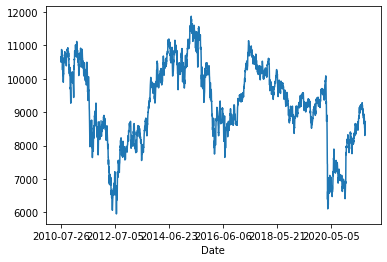

In [64]:
dataset['Close'].plot()

$\textbf{\large Data Preparation}$

Null or NaN's values must to be dropped from the data frame. Otherwise the algorithm may fail.

In [66]:
print('Null Values =', dataset.isnull().values.any())

Null Values = True


Since there are Null Values, we proceed to substitute them by the mean of each column.

In [67]:
for key in dataset.keys():
    dataset[key] = dataset[key].fillna(dataset[key].mean())
print('Null Values=', dataset.isnull().values.any())

Null Values= False


$\textbf{\large Evaluate Algorithms and Models}$

We have to partition our data set into the training set and the test set. The idea is to use the test set to confirm the good performance of our final model and understand if there is any overfitting. For example, we can use the 80\% of our data for modeling and 20\% for testing, as suggested by Tatsat et al. (2021).

In [69]:
X = list(dataset['Close'])
X = [float(x) for x in X]
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

We are now ready to code our algorithm up, which in simple words just decides whether tu buy, sell or hold regarding the current market price.

The algorithm evaluates which action needs to be taken to optimise our strategy based on a $Q$-value. This $Q$-value determines the value of taking an action at a certain state, and also the value of the latter. To do so, we are going to use a deep $Q$-network which uses an ANN to approximate $Q$-values. Hence, the action value function should be defined as $Q_\theta(s,a)$m wgere $\theta$ is a vector of weights of a multilayered DQN that maps states to actions, which must be learnt in the process when approximating the $Q$-value function. 

We will need many modules and functions (see Tatsat et al, 2021):

1. Agent class. This holds the variables and member functions that perform the $Q$-learning. An object of the ``Agent'' class is created using the training phase and is used for training the model.

2. Helper functions.

3. Training module. During traininng, the prescribed action for each day is predicted, the rewards are computed, and the deep learning-based $Q$-learning model weights are updated over a number of episodes. All of this is done making use of the functions agent and helper methods. This provides us with one of the three actions mentioned above based on the stock price at the end of the day on each state. Additionally, the profit and loss of each action is summed to determine whether an overall profit has occurred. $\textbf{Aim}$: to maximise the total profit.

$\textbf{Agent script}.–$

This is the key step, because we are creating the agent we will train that will perform RL based on the the Q-learning. We will perform the following steps to achieve this.

1. Create an agent class. Its initial function takes in the $\textit{batch size, state size}$ and $\textit{evaluation Boolean function}$ to check whether the trainin is ongoing.

2. In the agent class, two methods are needed:

$\hspace{1.3cm}$ 2.1. Constructor: It nitialises the parameters.

$\hspace{1.3cm}$ 2.2. Model: This function has a deep learning model to map the state toaction.

$\hspace{1.3cm}$ 2.3. Act Function: Given a state, returns an action using the output of the model function. Three possible actions.

$\hspace{1.3cm}$ 2.4. expReplay: The Replay function adds samples and evaluates a buffer. "Add a new experience to the replay buffer memory. Randomly sample a batch of experienced tuples from the memory. In the following function, we randomly sample states from a memory buffer. Experience replay stores a history of state, action, reward, and next state transitions that are experienced by the agent. It randomly samples mini-batches from this experience to update the network weights at each time step before the agent selects an $\epsilon$-greedy action."

In [72]:
class Agent:

    def __init__(self, state_size, is_eval = False, model_name = ""):
        self.state_size     = state_size # normalised previous days
        self.action_size    = 3 # hold, buy and sell
        self.memory         = deque(maxlen=1000)
        self.inventory      = []
        self.model_name     = model_name
        self.is_eval        = is_eval
    
        self.gamma          = 0.95
        self.epsilon        = 1.0
        self.epsilon_min    = 0.01
        self.epsilon_decay  = 0.995

        self.model = load_model(model_name) if is_eval else self._model()
    
    #Deep Q Learning model returns the q-value when given state as input
    def _model(self):
        model = Sequential()
        # Input Layer 
        model.add(Dense(units=64, input_dim = self.state_size, activation = "relu"))
        # Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        # Output Layer
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer = Adam(lr=0.001))
        return model
    
    #Return the action on the value function
    # With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    # With probability ($\epsilon$) choose any action at random.
    # Intitially high epsilon-more random, later less
    # The trained agents were evaluated by different initial random condition
    # and an e-greedy policy with epsilon 0.05. 
    # This procedure is adopted to minimize the possibility of overfitting during evaluation.

    def act(self, state):
        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random 
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        
        options = self.model.predict(state)
        # action is based on the action that has the highest value from the q-value function.
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        # 1: Prepare replay memory
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])

        # 2: Loop across the replay memory batch (during the training phase)
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t
            # 3: Update the target for Q table. Table equation:
            if not done:
                # set_trace()
                # max of the array of the predicted
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            # 4: Q-value of the state currently from the table (predict it using a deep learning model)
            target_f = self.model.predict(state)
            # 5: Update the output Q table for the given action in the table (the Q-value of this state for the action
            # in the current replay is set to the target)
            target_f[0][action] = target
            # 6: Train and fit the model.abs (the deep learning model weigths are updated) where state is X
            # and target_f is Y, where the target is updated.
            self.model.fit(state, target_f, epochs=1, verbose=0)

        #7: Implement epsilon greddy algorithm (this approach selects an action randomly with a probability 
        # of ε or the best action, according to the Q-value function, with probability 1 - ε).
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

$\textbf{Helper functions}$.–

In [73]:
import numpy as np
import math

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# # returns the vector containing stock data from a fixed file 
# def getStockData(key):
#     vec = []
#     lines = open("data/" + key + ".csv", "r").read().splitlines()

#     for line in lines[1:]:
#         vec.append(float(line.split(",")[4])) #Only Close column

#     return vec

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t

def getState(data, t, n):    
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

$\textbf{Training the data}$.–

Here we are going to train the data based on our agend and helper methods. The idea is to obtain the best action (buy, sell, hold) based on the stock price at the end of each day. The training consists in teaching the algorithm to predict the best action by prescribing it given the current state. Further, the price of the action is calculated. The cumulative sum will be thus calculate at the end of the period to check the performance (profit or loss). 

In [82]:
from IPython.core.debugger import set_trace
# 1. Define the number of market days ("window" size)
window_size = 1
agent = Agent(window_size)
# In this step we feed the closing value of the stock price (read data from the CSV file)
data = X_train
l = len(data) - 1
print(l)
# Define the batch size with which the neural work will be trained
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 10
# Start to iterate through episodes
for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    # Each episode has to be started with a state based on the data and window size. 
    # The inventory of stocks is initialised before going through the data.
    state = getState(data, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    # Start to iterate over every day of the stock data. The action probability is predicted
    # by the agent
    for t in range(l):
        # The agent acts every day of the training proces. 
        action = agent.act(state)    
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0
        # Based on that action, the stock is bought...
        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            #print("Buy: " + formatPrice(data[t]))
        # ... or sold
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)      
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            # print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        # if action is 0, then we hold and nothing has to be done
        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each 
            plot_behavior(data,states_buy, states_sell, total_profit)
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)    
            

    if e % 2 == 0:
        agent.model.save("model_ep" + str(e))

Running episode 0/10
Buy: $10645.00
Buy: $10499.80
Buy: $10835.40
Buy: $10871.40
Sell: $10843.30 | Profit: $198.30
Sell: $10840.00 | Profit: $340.20
Buy: $10651.10
Buy: $10812.60
Buy: $10374.80
Sell: $10258.30 | Profit: -$577.10
Buy: $10369.50
Buy: $10221.20
Buy: $10052.30
Buy: $10004.40
Sell: $10148.20 | Profit: -$723.20
Sell: $10187.00 | Profit: -$464.10
Sell: $10544.80 | Profit: -$267.80
Buy: $10537.60
Buy: $10599.40
Buy: $10622.70
Sell: $10479.10 | Profit: $104.30
Buy: $10586.20
Buy: $10751.80
Sell: $10716.80 | Profit: $347.30
Buy: $10743.10
Buy: $10762.50
Buy: $10555.20
Buy: $10727.60
Sell: $10613.00 | Profit: $391.80
Sell: $10486.80 | Profit: $434.50
Buy: $10514.50
Sell: $10450.10 | Profit: $445.70
Sell: $10383.00 | Profit: -$154.60


KeyboardInterrupt: 